In [1]:
import os
import sys
import pickle
import pandas as pd
import seaborn as sns
from copy import deepcopy
from matplotlib import pyplot as plt
from IPython.display import clear_output
from matplotlib.colors import TABLEAU_COLORS

sys.path.append('..')
from notebook_utils import Data, train, run_study, test_vanilla, test_uncertain

sys.path.append('../../..')
from uncertain.pairwise_ranking.MF import bprMF, UncertainMF, PretrainedUncertainMF
from uncertain.extras import Resample


if os.path.isfile('data.pkl'):
    with open('data.pkl', 'rb') as f:
        data = pickle.load(f)
    print(f'MovieLens data prepared: {data.n_user} users, {data.n_item} items.')
    print(f'{len(data.train)} train, {len(data.val)} validation and {len(data.test)} test interactions.')
else:
    data = pd.read_csv('data.csv')
    data.columns = ['user', 'item', 'score', 'timestamps']
    data = Data(data)
    with open('data.pkl', 'wb') as f:
        pickle.dump(data, f, protocol=4)
        
base_conf = {'embedding_dim':10, 'lr':0, 'weight_decay':0}
trials = 50 ## 0 for eval only mode

MovieLens data prepared: 6040 users, 3416 items.
644083 train, 158002 validation and 197526 test interactions.


In [2]:
f'batch size: ({2**8}, {2**10}) - learning rate: ({1e-5}, {1e-3} - weight_decay: {1e-5, 1e-3})'

'batch size: (256, 1024) - learning rate: (1e-05, 0.001 - weight_decay: (1e-05, 0.001))'

# bprMF

In [2]:
name = 'MF-BPR'
def init_model(**kwargs):
    return bprMF(data.n_user, data.n_item, **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 2**8, 2**10)
    params = {'embedding_dim': trial.suggest_int('dim', 200, 200),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-5, 1e-3)}
    '''
    'weight_decay': (trial.suggest_float('wd_user', 1e-4, 1e-2), 
                     trial.suggest_float('wd_item', 1e-4, 1e-2), 
                     trial.suggest_float('wd_neg_item', 1e-4, 1e-2))
    '''
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
baseline = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_vanilla(baseline, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

{'FCP': 0.8982918704373095, 'MAP': array([0.46804637, 0.5597682 , 0.5826987 , 0.5843681 , 0.5825028 ,
       0.5761069 , 0.5692268 , 0.5607982 , 0.5530335 , 0.5459491 ],
      dtype=float32), 'Recall': array([0.02809201, 0.05006997, 0.07077752, 0.08882254, 0.10476914,
       0.11943837, 0.13414644, 0.14802216, 0.16025732, 0.17276621],
      dtype=float32)}


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
0,0,0.81751,2022-06-24 19:51:42.275483,2022-06-24 19:55:53.939090,0 days 00:04:11.663607,375,200,0.000931,0.000513,/home/vcoscrato/Documents/RecSys/MF/tests/Pair...,COMPLETE


# Resample

{'FCP': 0.8777972678467018,
 'CP unc': 0.3569809163571421,
 'DP unc': 0.4415403933029076,
 'PUR': 0.808489827367265,
 'corr_usup': -0.07294135310594756,
 'corr_isup': -0.5298243772695939,
 'MAP': array([0.3254889 , 0.40420946, 0.43141642, 0.439712  , 0.4412381 ,
        0.4389585 , 0.43406326, 0.43011907, 0.42577586, 0.41976961],
       dtype=float32),
 'Recall': array([0.0311114 , 0.05383229, 0.07430899, 0.09233557, 0.10926826,
        0.12547013, 0.14011091, 0.15301642, 0.1646802 , 0.1764705 ],
       dtype=float32),
 'URI': 0.027713900431990623,
 'UAC': -0.20619464704785612}

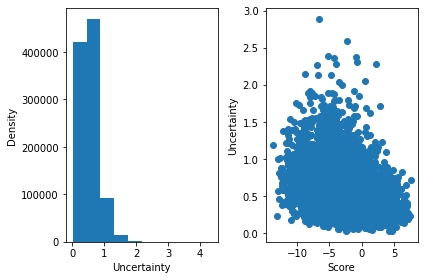

In [5]:
# Load params
best_params = study.best_params
data.batch_size = best_params['bs']
best_params = {'embedding_dim': best_params['dim'], 'lr': best_params['lr'], 'weight_decay': best_params['wd']}

# Train
if trials > 0:
    og = deepcopy(data.train)
    for i in range(5):
        data.train = og[np.random.choice(len(og), int(0.8*len(og)), replace=False), :]
        model = init_model(**best_params)
        train(model, data, path='checkpoints/resample', name=f'{i}')
    data.train = og
    
# Load resample models
models = []
for file in os.listdir('checkpoints/resample'):
    models.append(init_model(**base_conf))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/resample', file))
resample = Resample(init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0]), models)
results_resample = test_uncertain(resample, data, name='RESAMPLE', max_k=10)
clear_output(wait=True)
results_resample

# UncertainMF

{'FCP': 0.8580591922076081, 'CP unc': 0.028339105, 'DP unc': 0.019325295, 'PUR': 1.4664254, 'corr_usup': -0.0761756929502882, 'corr_isup': -0.6835931014824487, 'MAP': array([0.39370862, 0.46465233, 0.48380247, 0.48855317, 0.48597428,
       0.48137087, 0.47619832, 0.47094962, 0.46523017, 0.4590125 ],
      dtype=float32), 'Recall': array([0.01851674, 0.0330146 , 0.04545331, 0.05654278, 0.0665885 ,
       0.07699507, 0.08639479, 0.09501948, 0.10334551, 0.11153483],
      dtype=float32), 'UAC': -0.05466915563934258, 'URI': array(-0.06112605, dtype=float32)}


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_dim_var,params_lr,params_wd,user_attrs_filename,state
0,0,0.859464,2022-06-24 20:14:05.249585,2022-06-24 20:17:42.775492,0 days 00:03:37.525907,714,200,23,0.000495,0.000022,/home/vcoscrato/Documents/RecSys/MF/tests/Pair...,COMPLETE


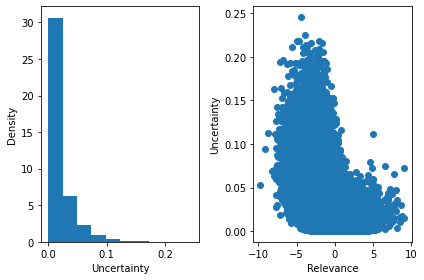

In [2]:
name = 'UMF-GPR'

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 2**8, 2**10)
    params = {'embedding_dim': trial.suggest_int('dim', 200, 200),
              'embedding_dim_var': trial.suggest_int('dim_var', 5, 50),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-6, 1e-4)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = UncertainMF(data.n_user, data.n_item, **params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
model = UncertainMF(data.n_user, data.n_item, 1, 1, 1, 1).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

In [12]:
model.recommend(0, n=100000)

,scores,uncertainties
28,8.941753,0.015098
383,8.165310,0.026340
37,7.991737,0.019640
387,7.887063,0.015083
106,7.877081,0.033618
...,...,...
1704,-10.012849,0.095838
2712,-10.237346,0.105781
3113,-10.600977,0.132379
2992,-10.797227,0.093214


# PretrainedUncertainMF

{'FCP': 0.875972288665639, 'CP unc': 0.21111779, 'DP unc': 0.32344583, 'PUR': 0.65271455, 'corr_usup': -0.01866311739146874, 'corr_isup': -0.9863956735399234, 'MAP': array([0.35764003, 0.4386808 , 0.46312562, 0.46833685, 0.4704098 ,
       0.4665743 , 0.4602295 , 0.45404476, 0.44790438, 0.44197664],
      dtype=float32), 'Recall': array([0.03349204, 0.05915081, 0.07983989, 0.09747747, 0.11492819,
       0.1317519 , 0.14455113, 0.15911782, 0.17131017, 0.18343054],
      dtype=float32), 'URI': 0.05292516574263573, 'UAC': -0.17584292623898248}


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
0,0,0.879083,2022-06-24 10:58:34.046237,2022-06-24 11:02:56.976133,0 days 00:04:22.929896,379,22,0.0001,0.0,/home/vcoscrato/Documents/RecSys/MF/tests/Pair...,COMPLETE
1,1,0.874339,2022-06-24 11:02:56.976881,2022-06-24 11:16:08.794699,0 days 00:13:11.817818,137,14,0.0001,0.0,/home/vcoscrato/Documents/RecSys/MF/tests/Pair...,COMPLETE


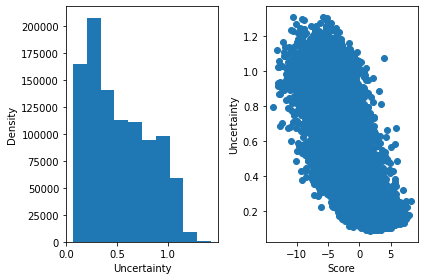

In [4]:
name = 'Pretrained-UMF-GPR'

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 2**8, 2**10)
    params = {'embedding_dim': trial.suggest_int('dim', 5, 50),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-6, 1e-4)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = PretrainedUncertainMF(baseline, **params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = PretrainedUncertainMF(baseline, 1, 1, 1).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

In [9]:
model.recommend(0, n=100000)

,scores,uncertainties
1011,4.687313,0.003600
1037,4.274357,0.000705
1622,4.274243,0.000628
252,4.125879,0.010324
392,4.020418,0.000115
...,...,...
2554,-8.550655,0.147850
2719,-8.891390,0.215354
2056,-8.919237,0.208112
2325,-9.182402,0.055693


# Results

In [5]:
# Load results
results = {}
for key in os.listdir('results'):
    results[key.replace('.pkl', '')] = pickle.load(open(os.path.join('results', key), 'rb'))
order = ['MF-BPR', 'RESAMPLE', 'UMF-GPR', 'Pretrained-UMF-GPR']
results = pd.DataFrame([results[key] for key in order], index=order)

# Plot aestetics
colors = [c for c in list(TABLEAU_COLORS)] + ['k', 'b', 'g', 'r']
colors = {k:c for k, c in zip(results.index, colors)}
lines = ['o', 'v', '^', '<', '>', 's', 'p', '+', 'x', '*']
lines = {k: '-' + l for k, l, in zip(results, lines)}

# Results
results[['FCP', 'CP unc', 'DP unc', 'PUR', 'URI', 'UAC']]

,FCP,CP unc,DP unc,PUR,URI,UAC
BPR,0.877797,NaN,NaN,NaN,NaN,NaN
RESAMPLE,0.877797,0.356981,0.441540,0.808490,0.027714,-0.206195
UncertainMF_initstd=1,0.888800,0.010101,0.015762,0.640845,0.038438,-0.238467
UncertainMF_init=random,0.884176,1.087529,1.060056,1.025916,0.000870,-0.053676
PretrainedUncertainMF,0.877797,0.013126,0.036881,0.355906,0.111047,-0.241003
UncertainGMF,0.886107,0.043446,0.411274,0.105637,0.126844,-0.199853
PretrainedUncertainMF_keeptraining,0.875972,0.211118,0.323446,0.652715,0.052925,-0.175843


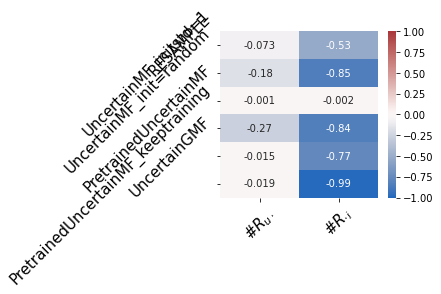

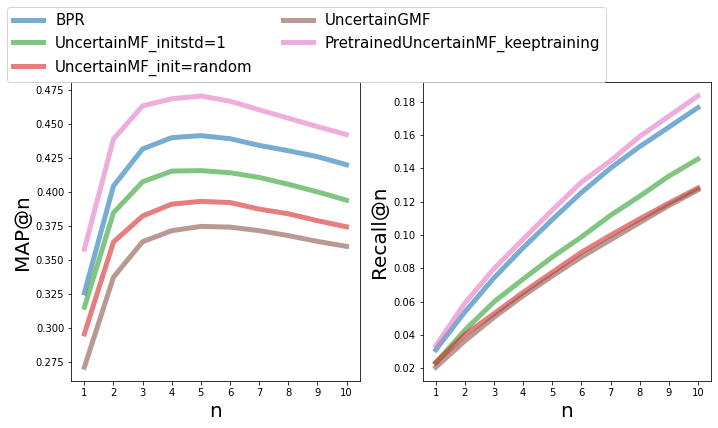

In [9]:
## Correlation plot
corr = results.drop('BPR', axis=0).filter(like='corr', axis=1)
corr.columns = [r'#$R_{u\cdot}$', r'#$R_{\cdot i}$']
sns.heatmap(corr.round(3), annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
plt.xticks(rotation=45, fontsize=15)
plt.yticks(rotation=45, fontsize=15)
plt.tight_layout()
plt.savefig('plots/corr.pdf')

## Top-K accuracy metrics
f, ax = plt.subplots(figsize=(10, 5), ncols=2)
for index, row in results.drop(['RESAMPLE', 'PretrainedUncertainMF'], axis=0).iterrows():
    ax[0].plot(np.arange(1, 11), row['MAP'], '-', color=colors[index], label=index, linewidth=5, alpha=0.6)
    ax[1].plot(np.arange(1, 11), row['Recall'], '-', color=colors[index], label=index, linewidth=5, alpha=0.6)
ax[0].set_xticks(np.arange(1, 11))
ax[0].set_xlabel('n', fontsize=20)
ax[0].set_ylabel('MAP@n', fontsize=20)
ax[1].set_xticks(np.arange(1, 11))
ax[1].set_xlabel('n', fontsize=20)
ax[1].set_ylabel('Recall@n', fontsize=20)
handles, labels = ax[0].get_legend_handles_labels()
# f.legend(handles, labels, fontsize=15, ncol=2, bbox_to_anchor=(0.85, 1.1))
f.legend(handles, labels, fontsize=15, ncol=2, bbox_to_anchor=(0.85, 1.2))
f.tight_layout()
f.savefig('plots/accuracy.pdf', bbox_inches="tight")